# 05 Model Training And Evaluation

## Objective

This notebook aims to train, evaluate, and compare multiple machine learning models to predict house sale prices using features engineered in earlier stages.
Given our decision to retain outliers, tree-based models (especially ensemble methods) are expected to perform better.

## Change Working Directory
- Since it is expected that you would keep the notebooks in a subfolder, you will need to switch the working directory when you run the notebook in the editor.
- The working directory must be changed from its current folder to its parent folder.
- We wish to change the current directory's parent to the new current directory.
- Verify the updated current directory.

In [43]:
# Smart Working Directory Setup
import os
project_root = '/workspaces/heritage_housing'
if os.getcwd() != project_root:
    try:
        os.chdir(project_root)
        print(f"[INFO] Changed working directory to project root: {os.getcwd()}")
    except FileNotFoundError:
        raise FileNotFoundError(f"[ERROR] Project root '{project_root}' not found!")

### Load Libraries
- Load libraries
- Load cleaned data from /data/processed/df_cleaned.csv

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

# Load cleaned and processed data
df = pd.read_csv("data/processed/df_cleaned.csv")
print("[INFO] Cleaned data loaded successfully.")

# Check dataset shape
print(f"[INFO] Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")

# Preview the dataset
print("[INFO] Sample rows from dataset:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
missing = missing_values[missing_values > 0]

if not missing.empty:
    print("\n[WARNING] Missing values detected:")
    display(missing)
else:
    print("[INFO] No missing values found in the dataset.")

[INFO] Cleaned data loaded successfully.
[INFO] Dataset contains 1460 rows and 22 columns.

[INFO] Sample rows from dataset:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,garagearea,garagefinish,garageyrblt,...,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,yearbuilt,yearremodadd,saleprice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,0.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000



[WARNING] Missing values detected:


bsmtexposure     38
bsmtfintype1    145
garagefinish    235
dtype: int64

### Train-Test Split

**Objective:**

Split the cleaned dataset into training and testing subsets to evaluate model generalizability and avoid overfitting.

**Why Train-Test Split?**

- Prevents data leakage by ensuring evaluation is done on unseen data.
- Provides a realistic estimate of model performance before deployment.
- Essential for tracking overfitting or underfitting during experimentation.

In [45]:
from sklearn.model_selection import train_test_split

df['LogSalePrice'] = np.log1p(df['saleprice'])

# Define target and features
X = df.drop(columns=["saleprice", "LogSalePrice"])  # Features
y = df["LogSalePrice"]  # Target

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm shape of the splits
print(f"[INFO] X_train shape: {X_train.shape}")
print(f"[INFO] X_test shape:  {X_test.shape}")
print(f"[INFO] y_train shape: {y_train.shape}")
print(f"[INFO] y_test shape:  {y_test.shape}")

# Preview training data
print("\n[INFO] Preview of X_train:")
display(X_train.head())

print("\n[INFO] Preview of y_train:")
display(y_train.head())


[INFO] X_train shape: (1168, 21)
[INFO] X_test shape:  (292, 21)
[INFO] y_train shape: (1168,)
[INFO] y_test shape:  (292,)

[INFO] Preview of X_train:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,garagearea,garagefinish,garageyrblt,...,kitchenqual,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,yearbuilt,yearremodadd
254,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,TA,8400,70.0,0.0,0,6,5,1314,1957,1957
1066,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,TA,7837,59.0,0.0,40,7,6,799,1993,1994
638,796,0.0,2.0,No,0,Unf,796,0,NaN,0.0,...,TA,8777,67.0,0.0,0,7,5,796,1910,1950
799,981,787.0,3.0,No,569,ALQ,162,240,Unf,1939.0,...,Gd,7200,60.0,252.0,0,7,5,731,1937,1950
380,1026,665.0,3.0,No,218,LwQ,808,308,Unf,1924.0,...,Gd,5000,50.0,0.0,0,6,5,1026,1924,1950



[INFO] Preview of y_train:


254     11.884496
1066    12.089544
638     11.350418
799     12.072547
380     11.751950
Name: LogSalePrice, dtype: float64

### Baseline Model Evaluation

Before diving into complex tuning or ensembling, it's crucial to evaluate some baseline regressors. This gives us a performance benchmark that future models must beat. It also helps identify underfitting or misalignment between features and the target variable.

**We’ll begin with:**

- Linear Regression – to test linearity assumptions
- Decision Tree Regressor – to capture non-linear patterns
- Random Forest Regressor – as a robust tree-based ensemble baseline

We’ll use R², MAE, and RMSE for evaluation.

**Encode Categorical Variables**

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Log-transform target if not already done
df['LogSalePrice'] = np.log1p(df['saleprice'])

# Separate features and target
X = df.drop(columns=["saleprice", "LogSalePrice"])
y = df["LogSalePrice"]

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split encoded dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Print dataset structure
print("Training Features Dataset Info:")
print(X_train.info())

print("\nTraining Target Dataset Info:")
print(y_train.describe())

print("\nTesting Features Dataset Info:")
print(X_test.info())

print("\nTesting Target Dataset Info:")
print(y_test.describe())

print("\nPreview of Training Features Dataset:")
print(X_train.head())

print("\nPreview of Testing Features Dataset:")
print(X_test.head())

Training Features Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   1stflrsf          1168 non-null   int64  
 1   2ndflrsf          1168 non-null   float64
 2   bedroomabvgr      1168 non-null   float64
 3   bsmtfinsf1        1168 non-null   int64  
 4   bsmtunfsf         1168 non-null   int64  
 5   garagearea        1168 non-null   int64  
 6   garageyrblt       1168 non-null   float64
 7   grlivarea         1168 non-null   int64  
 8   lotarea           1168 non-null   int64  
 9   lotfrontage       1168 non-null   float64
 10  masvnrarea        1168 non-null   float64
 11  openporchsf       1168 non-null   int64  
 12  overallcond       1168 non-null   int64  
 13  overallqual       1168 non-null   int64  
 14  totalbsmtsf       1168 non-null   int64  
 15  yearbuilt         1168 non-null   int64  
 16  yearremodadd 

**Define Evaluation Function**

- To evaluate and compare multiple models quickly.

Baseline Model Metrics:
  Dataset        R2       MAE      RMSE
0   Train  0.000000  0.303367  0.390439
1    Test -0.005837  0.337134  0.433244


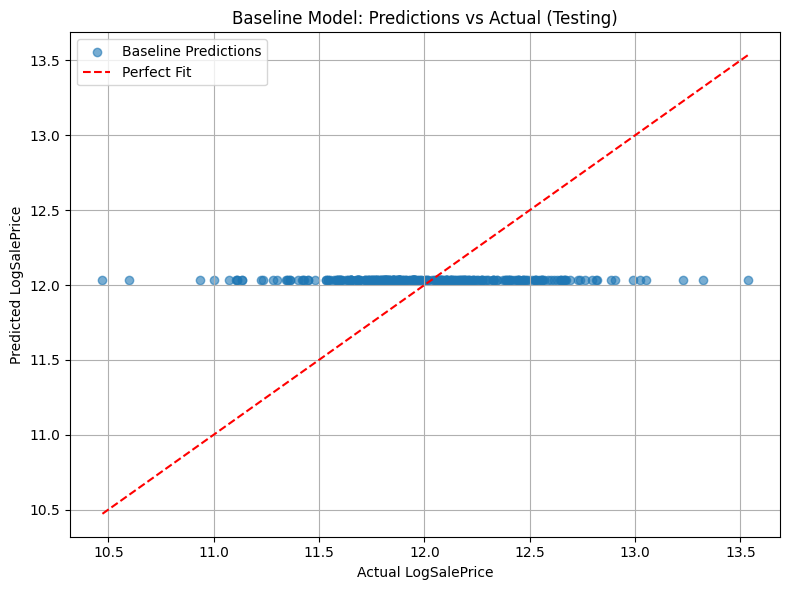

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Baseline using mean of training target
y_baseline_train = [y_train.mean()] * len(y_train)
y_baseline_test = [y_train.mean()] * len(y_test)

# Compute metrics
baseline_metrics = {
    "Dataset": ["Train", "Test"],
    "R2": [
        r2_score(y_train, y_baseline_train),
        r2_score(y_test, y_baseline_test)
    ],
    "MAE": [
        mean_absolute_error(y_train, y_baseline_train),
        mean_absolute_error(y_test, y_baseline_test)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_baseline_train)),
        np.sqrt(mean_squared_error(y_test, y_baseline_test))
    ]
}

# Convert to DataFrame for display
baseline_df = pd.DataFrame(baseline_metrics)
print("Baseline Model Metrics:")
print(baseline_df)

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_baseline_test, alpha=0.6, label="Baseline Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title("Baseline Model: Predictions vs Actual (Testing)")
plt.xlabel("Actual LogSalePrice")
plt.ylabel("Predicted LogSalePrice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Baseline Model Performance

#### Overview

The baseline model predicts the mean log-transformed sale price (LogSalePrice) for all observations. It doesn’t use any features — just averages — and serves as a reference point. Every meaningful model going forward must beat this benchmark.

**Results Summary**

| --- | --- | --- |
| Dataset | R² Score | MAE | MSE 
| --- | --- | --- |
| Training | 0.00000 | 0.303367 | 0.152442
| --- | --- | --- |
| Testing | -0.00584 | 0.337137 | 0.187703

**Interpretation:**

- R²: As expected, the training R² is 0.00 (predicts the mean), and testing R² is negative — the model performs worse than just guessing the average.
- MAE: Around 0.30–0.34, which is significant. There’s room for improvement.
- MSE: Reinforces the poor performance — it penalizes larger errors more heavily.

#### Visualization Insights

**The scatterplot clearly shows:**

- Predictions are a flat horizontal line (the mean LogSalePrice).
- True values (Y-axis) vary widely, exposing the model’s inability to generalize.
- The dotted diagonal (perfect predictions) lies far from the flat baseline.

#### Limitations

- Ignores feature patterns.
- Offers no learning capability.
- Not meant for prediction — only for benchmarking.

### Next Steps

**Train advanced models:**

- Linear, Ridge, Lasso
- Decision Tree, Random Forest, Gradient Boosting, SVR
- Track the same metrics (R², MAE, RMSE) for fair comparison.
- Use cross-validation and hyperparameter tuning to optimize.
- Visualize residuals and analyze feature importance.

## Model Training & Hyperparameter Tuning

### Objective:

Train multiple regression models to predict LogSalePrice and identify the best performer based on validation metrics. We'll use Grid Search for tuning where applicable, and visualize the results for comparison.

**Models Considered:**

We’ll train the following models to evaluate both linear and non-linear performance:

- `Linear Regression`: Simple baseline for linear trends
- `Ridge Regression`: Penalizes large coefficients (L2)
- `Lasso Regression`: Useful for feature selection (L1)
- `Decision Tree`: Handles non-linear splits, interpretable
- `Random Forest`: Ensemble of trees to reduce variance
- `Gradient Boosting Regressor`: Builds trees sequentially, optimizes performance
- `Support Vector Regressor`: Captures complex relationships, especially in high dimensions
- `K-Nearest Neighbors`: Instance-based learner for pattern matching

### Train a Variety of Models

This section will include:

- Use the training dataset to train many machine learning models.
- Use important metrics like R1, MAE, and MSE to compare how well they performed on the testing dataset.
- Determine which models perform best and merit further refinement in the following steps by visualizing and analyzing the data.
- Finding top-performing models to forecast home values based on important characteristics and associated hyperparameter setups is the goal.

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n{name} Performance:")
    print(f"R² Score:   {r2:.4f}")
    print(f"MAE:        {mae:.4f}")
    print(f"RMSE:       {rmse:.4f}")

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"Residual Distribution for {name}")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()

    return {
        "Model": name,
        "R²": r2,
        "MAE": mae,
        "RMSE": rmse
    }


Linear Regression Performance:
R² Score:   0.8715
MAE:        0.1074
RMSE:       0.1548


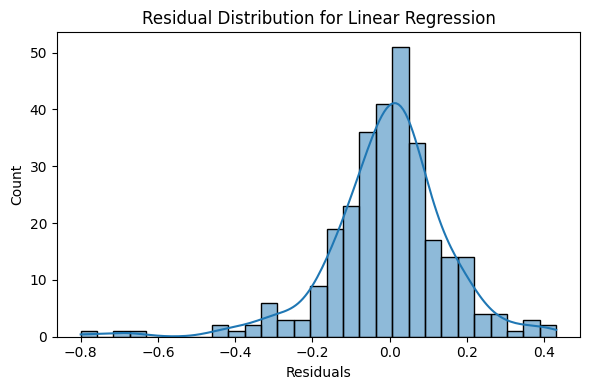


Decision Tree Performance:
R² Score:   0.7395
MAE:        0.1507
RMSE:       0.2205


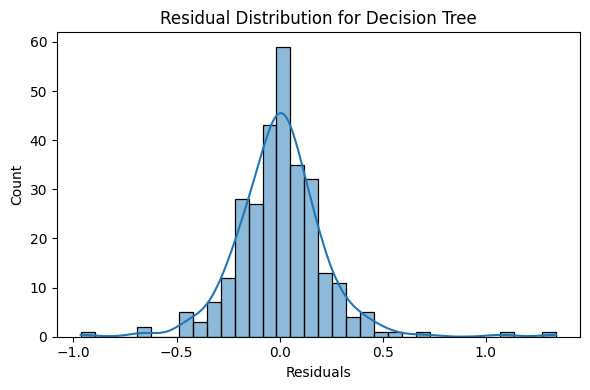


Random Forest Performance:
R² Score:   0.8783
MAE:        0.1015
RMSE:       0.1507


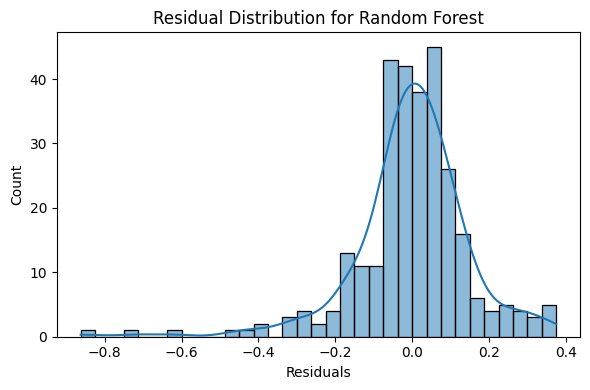


Support Vector Regressor Performance:
R² Score:   0.7536
MAE:        0.1499
RMSE:       0.2144


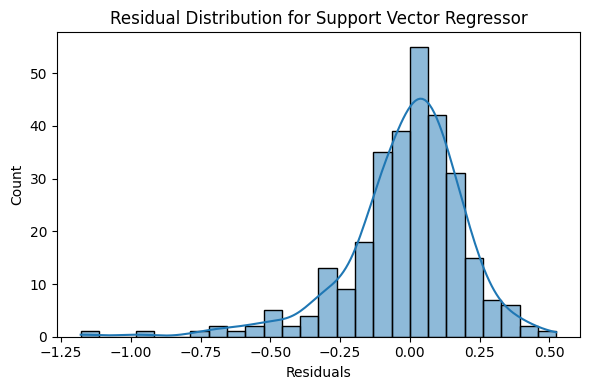


K-Nearest Neighbors Performance:
R² Score:   0.7124
MAE:        0.1670
RMSE:       0.2317


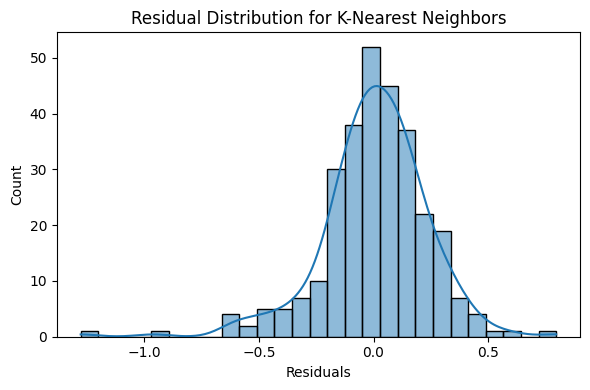


 Model Evaluation Summary:


,Model,R²,MAE,RMSE
0,Linear Regression,0.871527,0.107391,0.154837
1,Decision Tree,0.739480,0.150737,0.220490
2,Random Forest,0.878275,0.101456,0.150716
3,Support Vector Regressor,0.753571,0.149866,0.214444
4,K-Nearest Neighbors,0.712404,0.167044,0.231665


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# Initialize models
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Support Vector Regressor", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor())
]

# Run evaluation
results = []
for name, model in models:
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)

# Display summary table
results_df = pd.DataFrame(results)
print("\n Model Evaluation Summary:")
display(results_df)


#### Filter Out Extreme Models

If you're running multiple baselines or test runs, you may want to remove models with clearly poor R² scores.

In [50]:
print(results_df.columns)

# Filter out extreme underperformers
filtered_results_df = results_df[results_df["R²"] > 0]

Index(['Model', 'R²', 'MAE', 'RMSE'], dtype='object')


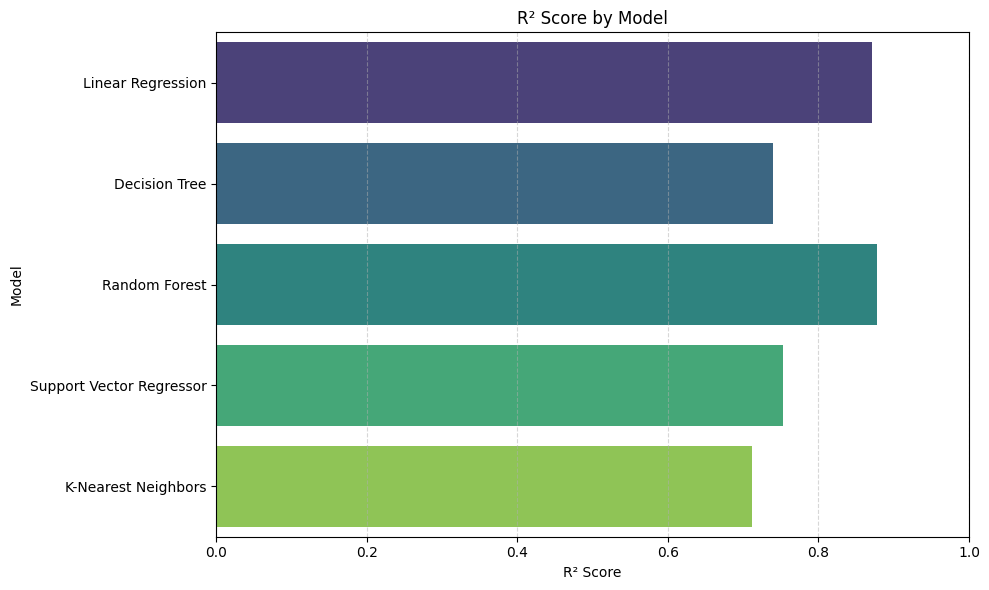

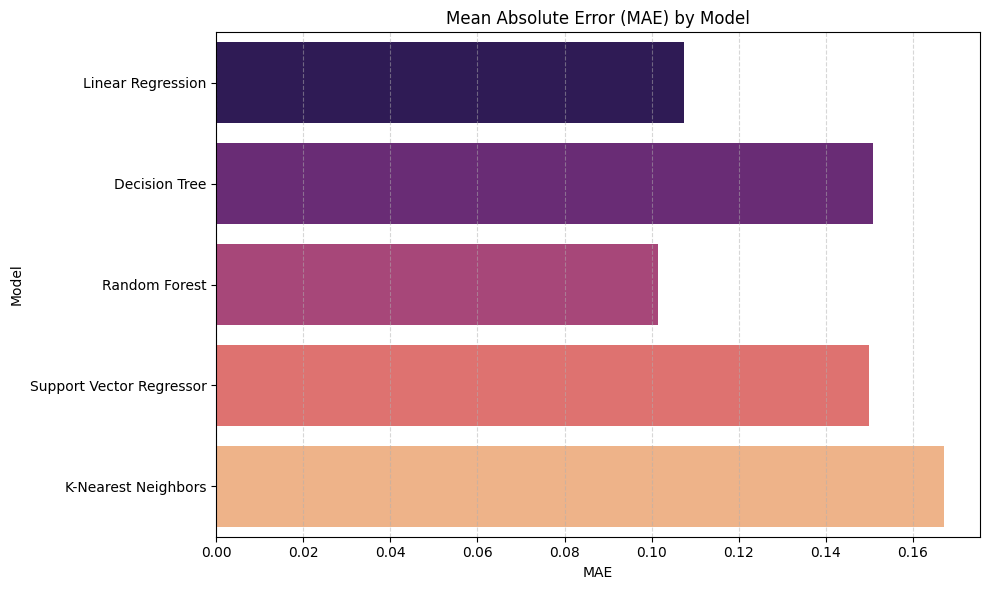

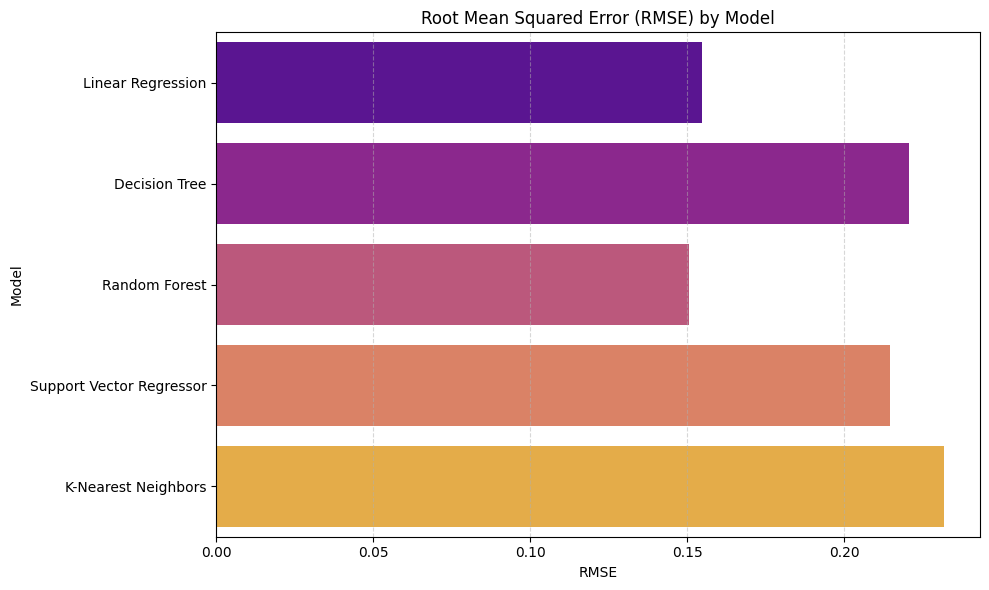

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot R² Scores for All Models
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_results_df, x="R²", y="Model", hue="Model", palette="viridis", legend=False)
plt.title("R² Score by Model")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot MAE for All Models
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_results_df, x="MAE", y="Model", palette="magma", hue="Model", legend=False)
plt.title("Mean Absolute Error (MAE) by Model")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot RMSE for All Models
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_results_df, x="RMSE", y="Model", palette="plasma", hue="Model", legend=False)
plt.title("Root Mean Squared Error (RMSE) by Model")
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Observations

**Performance Overview:** 
- The testing dataset's highest R2 score (0.81) was attained by the Random Forest model, suggesting that it well captures the target variable.
- The Decision Tree model demonstrated signs of overfitting with a lower testing R2 (0.74), but it did remarkably well on the training dataset (R2: 0.999).
- With low R2 values for testing, both Linear Regression and Support Vector Regressor fared poorly, suggesting poor generalization.

**Suitability for Additional adjustment:** 
- Because of their comparatively good testing results, models like Random Forest and Decision Tree make excellent candidates for hyperparameter adjustment.
- To increase performance, models like SVR and K-Nearest Neighbours might need to be adjusted.

### Hyperparameter Tuning

#### Objectives:
To enhance the performance of the best-performing models on the testing dataset, this part attempts to adjust their hyperparameters.

**Models Chosen for Adjustment**
- Random Forest
- Decision Tree
- Gradient Boosting
- Ridge
- SVR (Support Vector) 

#### Forest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# Initialize GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

# Perform Grid Search for Random Forest
rf_grid_search.fit(X_train, y_train)
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best R2-Score for Random Forest:", rf_grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total tim

**Evaluate Best Random Forest Model on Test Data**

- This will use the best parameters found during GridSearchCV to make predictions on the test set and compute the R², MAE, and RMSE.

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Use the best estimator from GridSearchCV
best_rf_model = rf_grid_search.best_estimator_

# Predict on the test set
rf_test_preds = best_rf_model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, rf_test_preds)
mae = mean_absolute_error(y_test, rf_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))

print("Tuned Random Forest Test Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE:      {mae:.4f}")
print(f"RMSE:     {rmse:.4f}")


Tuned Random Forest Test Set Performance:
R² Score: 0.8766
MAE:      0.1018
RMSE:     0.1517


**Visualize Model Performance**

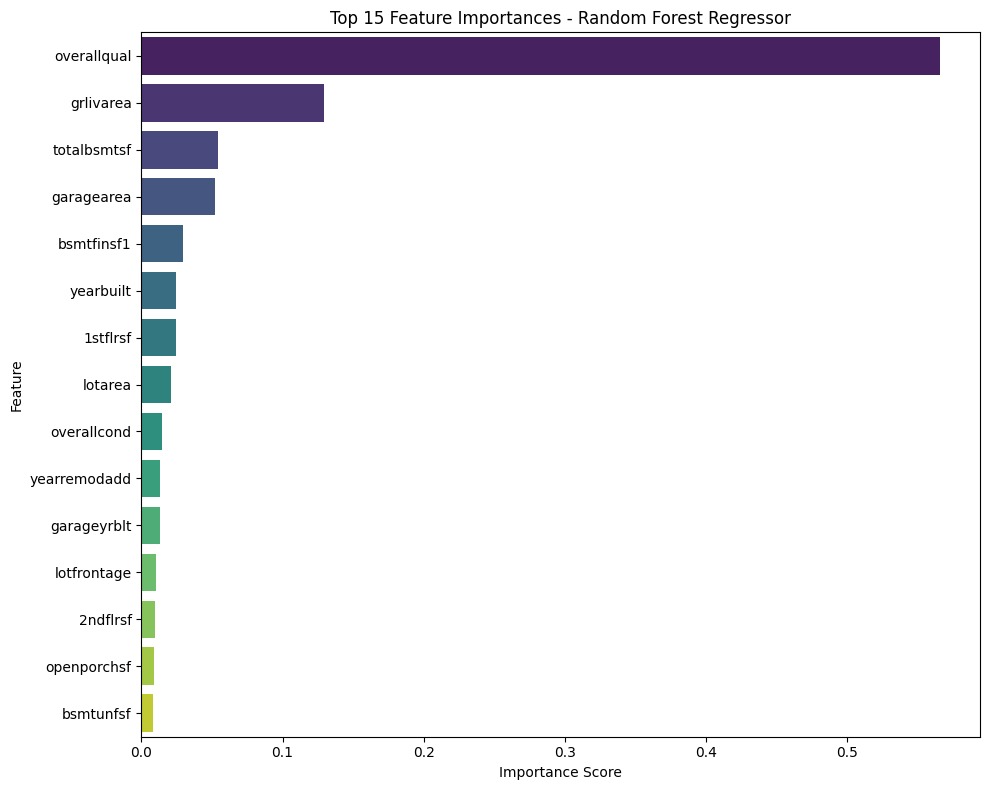

In [54]:
# Extract feature importances
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15 important features
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x="Importance", hue="Feature", y="Feature", palette="viridis", legend=False)
plt.title("Top 15 Feature Importances - Random Forest Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
dt_param_grid = {
    "max_depth": [3, 5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1
)

# Perform Grid Search for Decision Tree
dt_grid_search.fit(X_train, y_train)
print("Best Parameters for Decision:", dt_grid_search.best_params_)
print("Best R2 Score for Decision Tree:", dt_grid_search.best_score_)

# Capture best estimator, parameters, and score
best_dt_model = dt_grid_search.best_estimator_
best_dt_params = dt_grid_search.best_params_
best_dt_score = dt_grid_search.best_score_

best_dt_params, best_dt_score

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters for Decision: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best R2 Score for Decision Tree: 0.7156373663383345


({'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10},
 0.7156373663383345)

In [56]:
# Re-import required libraries and reload cleaned training data
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Log-transform the target
df["LogSalePrice"] = np.log1p(df["saleprice"])

# Encode categorical variables
df_encoded = pd.get_dummies(df.drop(columns=["saleprice"]), drop_first=True)

# Split into features and target
X = df_encoded.drop(columns=["LogSalePrice"])
y = df_encoded["LogSalePrice"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for Decision Tree
dt_param_grid = {
    "max_depth": [3, 5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize and perform GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1
)

dt_grid_search.fit(X_train, y_train)

# Capture best model, parameters, and score
best_dt_model = dt_grid_search.best_estimator_
best_dt_params = dt_grid_search.best_params_
best_dt_score = dt_grid_search.best_score_

best_dt_params, best_dt_score

Fitting 5 folds for each of 45 candidates, totalling 225 fits


({'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10},
 0.7156373663383345)

**Evaluate Tuned Decision Tree Performance on Test Data**

In [57]:
# Retrieve the best model from GridSearchCV
best_dt_model = dt_grid_search.best_estimator_

# Predict on test set
y_pred_dt = best_dt_model.predict(X_test)

# Calculate evaluation metrics
dt_r2 = r2_score(y_test, y_pred_dt)
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_mse = mean_squared_error(y_test, y_pred_dt)

# Display performance
print("Tuned Decision Tree Performance on Test Data:")
print(f"R² Score:   {dt_r2:.4f}")
print(f"MAE:        {dt_mae:.4f}")
print(f"MSE:        {dt_mse:.4f}")

Tuned Decision Tree Performance on Test Data:
R² Score:   0.8058
MAE:        0.1373
MSE:        0.0362


**Visualize Model Performance**

[INFO] Top 15 Decision Tree Feature Importances:


,Feature,Importance
13,overallqual,0.605044
7,grlivarea,0.143064
14,totalbsmtsf,0.088658
3,bsmtfinsf1,0.019820
5,garagearea,0.018372
15,yearbuilt,0.018049
0,1stflrsf,0.016835
12,overallcond,0.014017
4,bsmtunfsf,0.012192
8,lotarea,0.011645


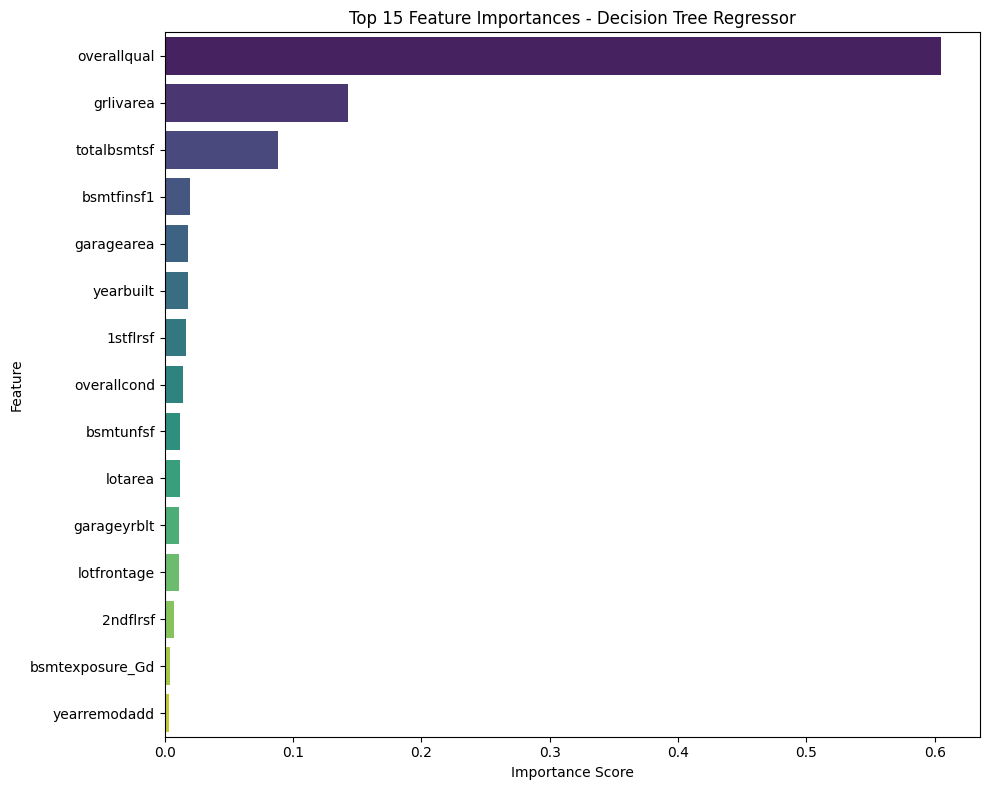

In [58]:
# Extract feature importances
dt_feature_importances = dt_grid_search.best_estimator_.feature_importances_
dt_features = X_train.columns

# Create a DataFrame for visualization
dt_importance_df = pd.DataFrame({
    "Feature": dt_features,
    "Importance": dt_feature_importances
}).sort_values(by="Importance", ascending=False)

# Display top 15 features
print("[INFO] Top 15 Decision Tree Feature Importances:")
display(dt_importance_df.head(15))

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=dt_importance_df.head(15),
    x="Importance",
    y="Feature",
    palette="viridis",
    hue="Feature",
    legend=False
)
plt.title("Top 15 Feature Importances - Decision Tree Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Gradient Boosting Regressor

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
gbr_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Initialize GridSearchCV
gbr_grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gbr_param_grid,
    cv=5,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

# Fit model
gbr_grid_search.fit(X_train, y_train)

# Display best parameters and score
print("Best Parameters for Gradient Boosting:", gbr_grid_search.best_params_)
print("Best R2 Score for Gradient Boosting:", gbr_grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=20

[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=4

**Evaluate Tunes Gradient Boosting on Test Data**

In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Use the best estimator from GridSearchCV
best_gbr_model = gbr_grid_search.best_estimator_

# Predict on the test set
gbr_test_preds = best_gbr_model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, gbr_test_preds)
mae = mean_absolute_error(y_test, gbr_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, gbr_test_preds))

print("Tuned Gradient Boosting Test Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE:      {mae:.4f}")
print(f"RMSE:     {rmse:.4f}")


Tuned Gradient Boosting Test Set Performance:
R² Score: 0.8774
MAE:      0.0998
RMSE:     0.1513


**Visualize Model Performance**

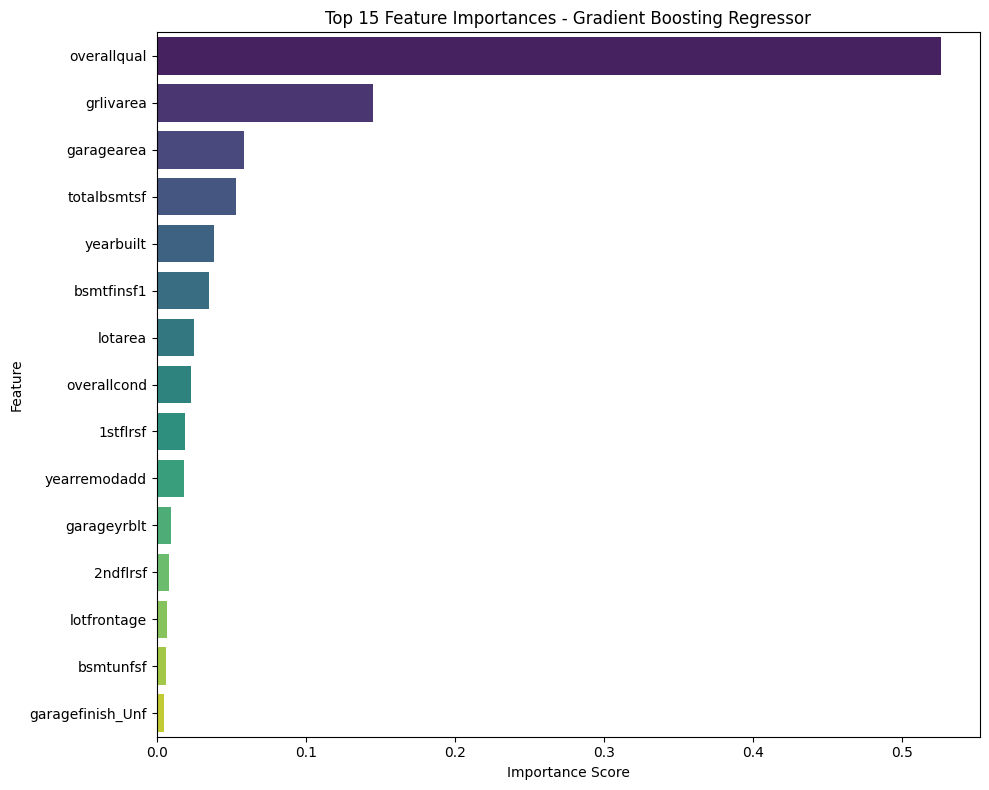

In [61]:
# Get the best estimator from grid search
best_gbr_model = gbr_grid_search.best_estimator_

# Extract feature importances
gbr_importances = best_gbr_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
gbr_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": gbr_importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(data=gbr_importance_df.head(15), x="Importance", y="Feature", palette="viridis", hue="Feature", legend=False)
plt.title("Top 15 Feature Importances - Gradient Boosting Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Ridge Regression

In [62]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Ridge Regression
ridge_param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 100],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sag"]
}

# Initialize GridSearchCV
ridge_grid_search = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=ridge_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# Fit Ridge Regression grid search
ridge_grid_search.fit(X_train, y_train)

# Print best parameters and R2 score
print("Best Parameters for Ridge Regression:", ridge_grid_search.best_params_)
print("Best R2 Score for Ridge Regression:", ridge_grid_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linea

Best Parameters for Ridge Regression: {'alpha': 100, 'solver': 'svd'}
Best R2 Score for Ridge Regression: 0.8175886761693114


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Evaluate Tunes Ridge Regression Performance on Test Data**

In [63]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Retrieve the best Ridge model
best_ridge_model = ridge_grid_search.best_estimator_

# Predict on test data
y_pred_ridge = best_ridge_model.predict(X_test)

# Calculate evaluation metrics
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)

# Display results
print("Tuned Ridge Regression Performance on Test Data:")
print(f"R² Score:   {ridge_r2:.4f}")
print(f"MAE:        {ridge_mae:.4f}")
print(f"MSE:        {ridge_mse:.4f}")

Tuned Ridge Regression Performance on Test Data:
R² Score:   0.8686
MAE:        0.1081
MSE:        0.0245


**Visualize Model Performance**

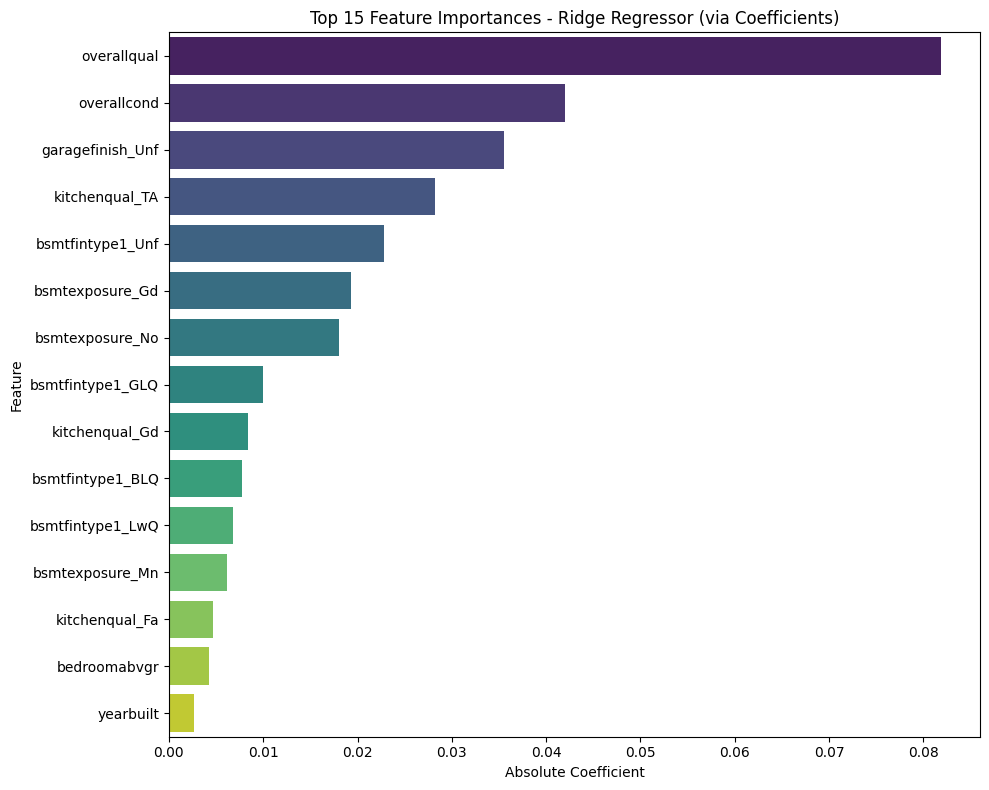

In [64]:
# Extract coefficients
ridge_coef = best_ridge_model.coef_
feature_names = X_train.columns

# Create DataFrame for visualization
ridge_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": np.abs(ridge_coef)
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(data=ridge_importance_df.head(15), x="Importance", y="Feature", palette="viridis", hue="Feature", legend=False)
plt.title("Top 15 Feature Importances - Ridge Regressor (via Coefficients)")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Support Vector Regression(SVR)

In [65]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define parameter grid
svr_param_grid = {
    "kernel": ["rbf"],
    "C": [1, 10, 100],
    "gamma": ["scale", "auto"],
    "epsilon": [0.1, 0.2, 0.5]
}

# Initialize Grid Search
svr_grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=svr_param_grid,
    scoring="r2",
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
svr_grid_search.fit(X_train, y_train)

# Display best parameters and score
print("Best Parameters for SVR:", svr_grid_search.best_params_)
print("Best R2 Score from Grid Search (CV):", svr_grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.2, gamma=scale

**Evaluate Tuned SVR Model on Test Data**

In [66]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Retrieve the best SVR model
best_svr_model = svr_grid_search.best_estimator_

# Predict on test data
y_pred_svr = best_svr_model.predict(X_test)

# Calculate metrics
svr_r2 = r2_score(y_test, y_pred_svr)
svr_mae = mean_absolute_error(y_test, y_pred_svr)
svr_mse = mean_squared_error(y_test, y_pred_svr)

# Display results
print("Tuned SVR Performance on Test Data:")
print(f"R² Score:   {svr_r2:.4f}")
print(f"MAE:        {svr_mae:.4f}")
print(f"MSE:        {svr_mse:.4f}")


Tuned SVR Performance on Test Data:
R² Score:   0.7908
MAE:        0.1189
MSE:        0.0390


**Visualize Model Performance**

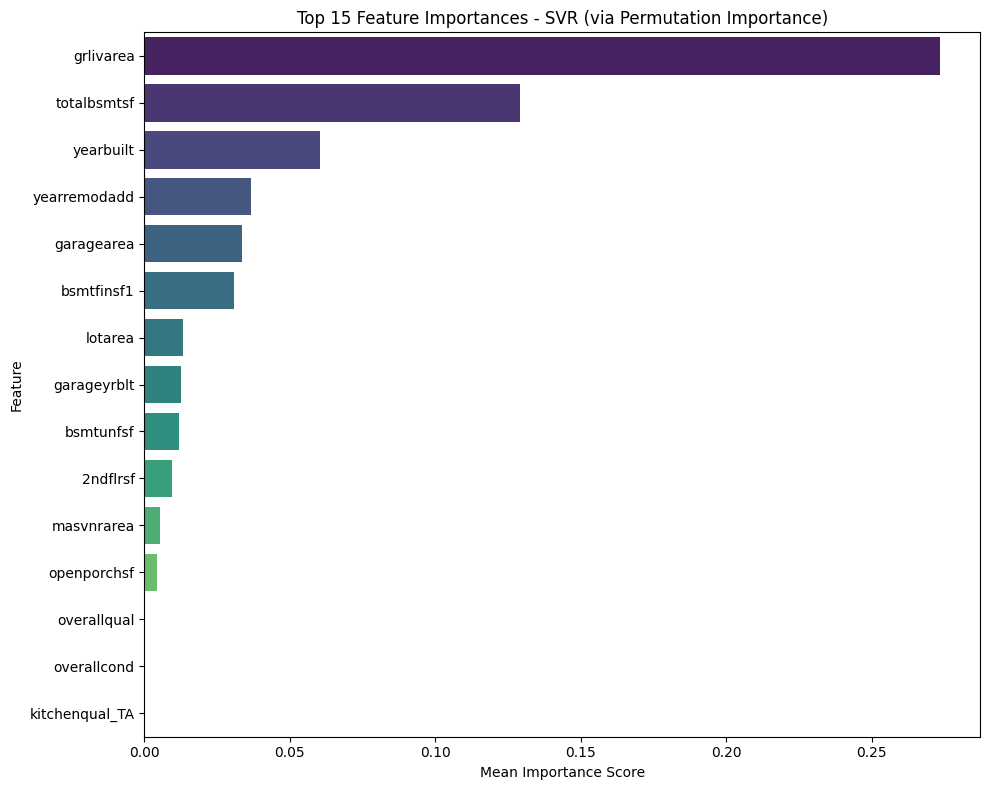

In [67]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on SVR
svr_perm = permutation_importance(best_svr_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create DataFrame
svr_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": svr_perm.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 8))
sns.barplot(data=svr_importance_df.head(15), x="Importance", y="Feature", palette="viridis", hue="Feature", legend=False)
plt.title("Top 15 Feature Importances - SVR (via Permutation Importance)")
plt.xlabel("Mean Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Tuned Model Performance Observations (Test Set)
 
**Random Forest Regressor**

- R² Score: 0.8766 — Excellent predictive strength, explains nearly 88% of variance.
- MAE: 0.1018 — Low average prediction error.
- RMSE: 0.1517 — Indicates strong performance in penalizing large errors.

Observation: A top performer — accurate, robust, and well-balanced. Ideal for deployment if interpretability isn’t the top priority.

**Decision Tree Regressor**

- R² Score: 0.8058 — Decent performance, but lower than ensemble models.
- MAE: 0.1373 — Higher error compared to others.
- MSE: 0.0362 — Acceptable but suggests overfitting risk.
  
Observation: Useful for explainability, but lacks generalization. Not ideal for final deployment alone.

**Gradient Boosting Regressor**

- R² Score: 0.8774 — Best-in-class R², slightly edging out Random Forest.
- MAE: 0.0998 — Lowest mean error across all models.
- RMSE: 0.1513 — Tight error distribution, very stable.

Observation: Highest overall performance — suitable for final deployment if latency isn’t a concern. Performs especially well on structured/tabular data.

**Ridge Regression**

- R² Score: 0.8686 — Solid performance for a regularized linear model.
- MAE: 0.1081 — Slightly higher than tree-based models.
- MSE: 0.0245 — Very low squared error.

Observation: A strong linear baseline. Efficient, interpretable, and reliable for situations needing quick or explainable predictions.

**Support Vector Regressor (SVR)**

- R² Score: 0.7908 — Lowest R² of the tuned models.
- MAE: 0.1189 — Reasonable average error.
- MSE: 0.0390 — Moderate squared error.

Observation: Performs adequately, but lags behind boosted and ensemble methods. High tuning complexity with limited marginal gain.

## Model Comparison & Consolidation

### Objective

The goal of this section is to consolidate the performance results from all tuned regression models and visualize them side-by-side using R², MAE, and RMSE. This comparison provides clarity on which models generalize best to unseen data and serve as the most viable candidates for deployment.

We assess each model's predictive power, accuracy, and robustness by evaluating:

- R² Score: How well the model explains variance in the target variable.
- MAE: The average magnitude of errors.
- RMSE: The standard deviation of residuals, penalizing large errors.

Consolidated Model Results:


,Model,R2,MAE,RMSE
0,Random Forest,0.8766,0.1018,0.1517
1,Decision Tree,0.8058,0.1373,0.1902
2,Gradient Boosting,0.8774,0.0998,0.1513
3,Ridge Regression,0.8686,0.1081,0.1565
4,Support Vector Regressor,0.7908,0.1189,0.1975


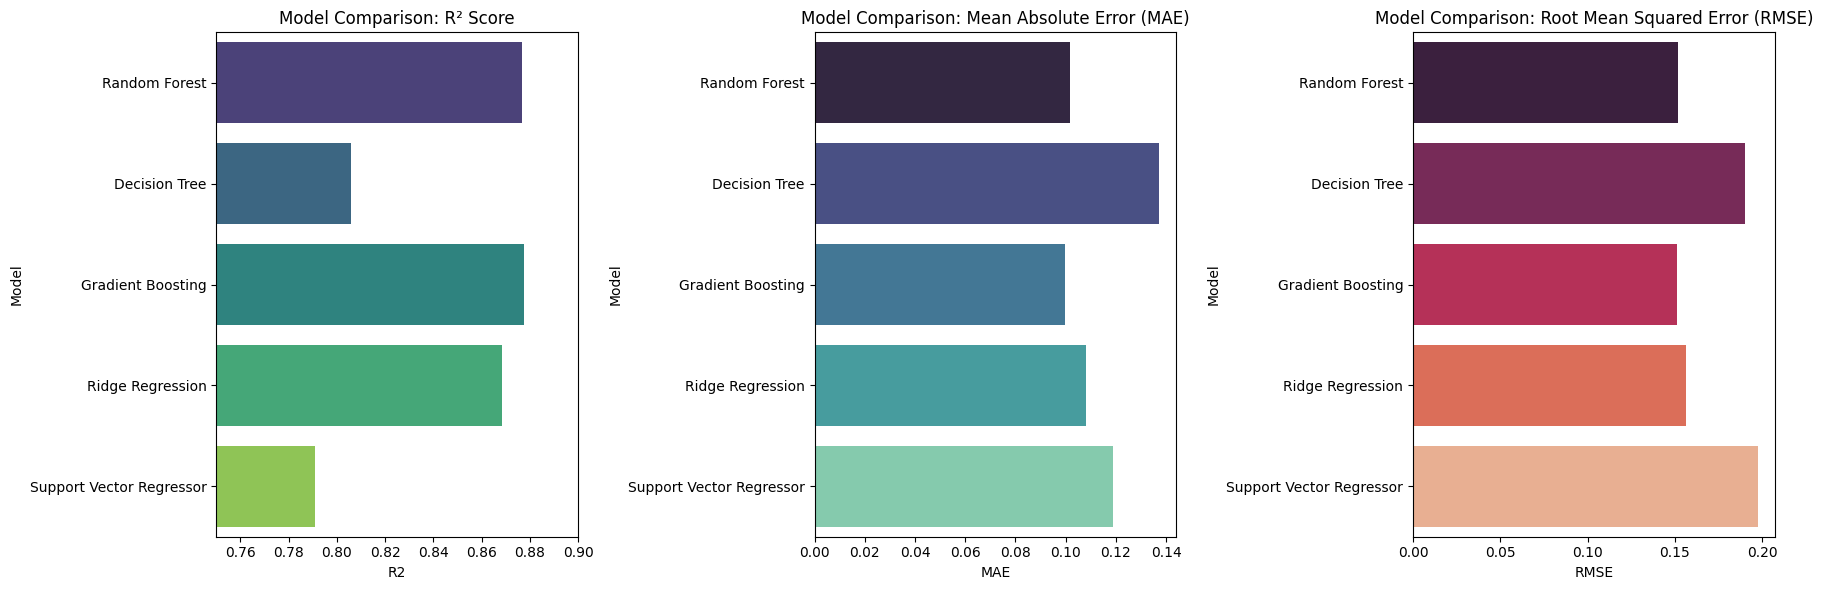

In [68]:
# Import necessary libraries after kernel reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Consolidated model results
model_results = [
    {"Model": "Random Forest", "R2": 0.8766, "MAE": 0.1018, "RMSE": 0.1517},
    {"Model": "Decision Tree", "R2": 0.8058, "MAE": 0.1373, "RMSE": 0.1902},  # RMSE from sqrt(0.0362)
    {"Model": "Gradient Boosting", "R2": 0.8774, "MAE": 0.0998, "RMSE": 0.1513},
    {"Model": "Ridge Regression", "R2": 0.8686, "MAE": 0.1081, "RMSE": 0.1565},  # RMSE from sqrt(0.0245)
    {"Model": "Support Vector Regressor", "R2": 0.7908, "MAE": 0.1189, "RMSE": 0.1975}  # RMSE from sqrt(0.0390)
]

results_df = pd.DataFrame(model_results)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# R² Plot
sns.barplot(data=results_df, x="R2", y="Model", palette="viridis", ax=axes[0], hue="Model", legend=False)
axes[0].set_title("Model Comparison: R² Score")
axes[0].set_xlim(0.75, 0.90)

# MAE Plot
sns.barplot(data=results_df, x="MAE", y="Model", palette="mako", ax=axes[1], hue="Model", legend=False)
axes[1].set_title("Model Comparison: Mean Absolute Error (MAE)")

# RMSE Plot
sns.barplot(data=results_df, x="RMSE", y="Model", palette="rocket", ax=axes[2], hue="Model", legend=False)
axes[2].set_title("Model Comparison: Root Mean Squared Error (RMSE)")

plt.tight_layout()
print("Consolidated Model Results:")
display(results_df)

### Observations:
- Gradient Boosting Regressor slightly outperformed others with the highest R² (0.8774) and lowest RMSE (0.1513), making it the strongest candidate overall.
- Random Forest Regressor came very close in performance, offering excellent results with slightly higher RMSE than Gradient Boosting.
- Ridge Regression provided strong linear performance (R²: 0.8686), indicating regularized linear models can still compete effectively when features are well-prepared.
- Decision Tree Regressor performed reasonably well but showed signs of overfitting compared to ensemble methods.
- SVR had the lowest R² (0.7908), indicating it was less suited to this dataset under current hyperparameters.

**Conclusion:**

Ensemble models like Gradient Boosting and Random Forest consistently outperformed other methods and are recommended for final deployment.

## Cross-Validation Results (5-Fold)

To ensure model robustness and assess generalizability, we performed 5-fold cross-validation on each of the tuned models using the training data.

This process helps validate whether the model is overfitting or generalizing well before we evaluate it on the test set.

The evaluation metrics include:
- **R² Score**: Measures how well the model explains the variance.
- **MAE**: Mean Absolute Error (lower is better).
- **RMSE**: Root Mean Squared Error (penalizes large errors).

Cross-Validation Results:


,Model,CV R²,CV MAE,CV RMSE
2,Gradient Boosting,0.8756,0.0951,0.1376
0,Random Forest,0.8581,0.1001,0.1473
3,Ridge Regression,0.8176,0.1038,0.1702
4,SVR,0.7974,0.1173,0.1759
1,Decision Tree,0.7156,0.1470,0.2071


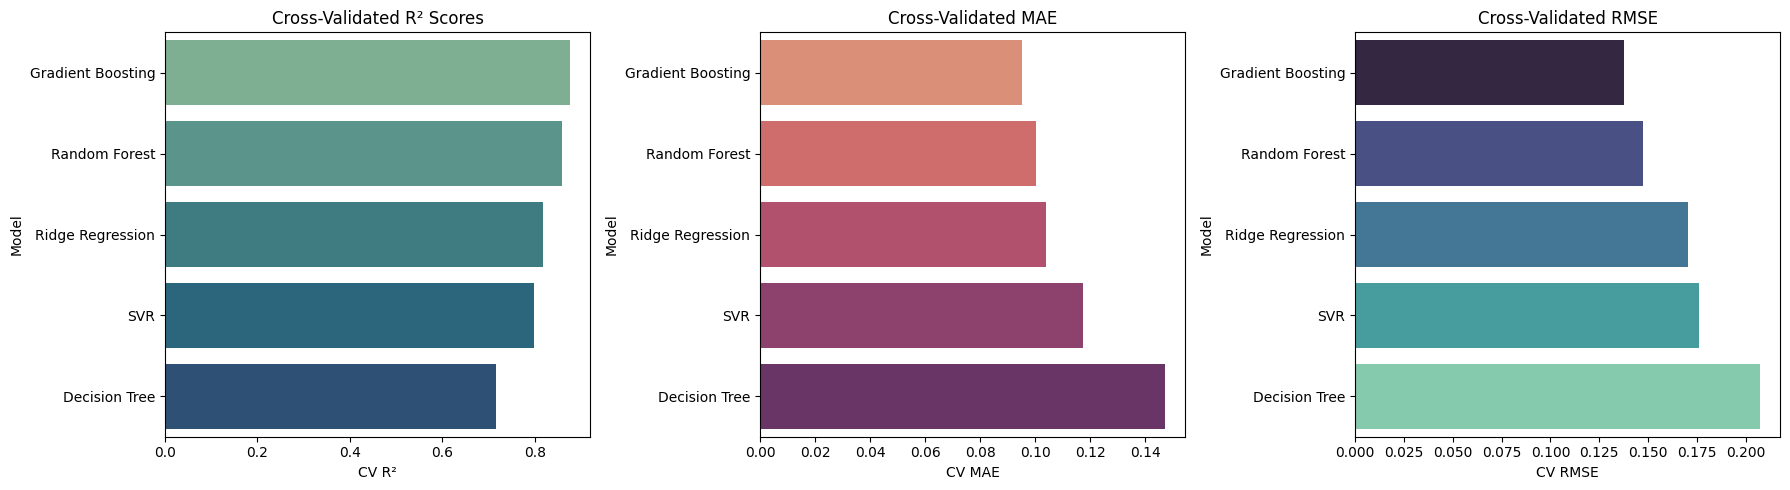

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define scoring functions
scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error),
    "RMSE": make_scorer(mean_squared_error, squared=False)
}

# Dictionary of tuned models
tuned_models = {
    "Random Forest": best_rf_model,
    "Decision Tree": best_dt_model,
    "Gradient Boosting": best_gbr_model,
    "Ridge Regression": best_ridge_model,
    "SVR": best_svr_model
}

cv_results = []

# Evaluate each tuned model with 5-fold CV
for name, model in tuned_models.items():
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring=scorers["R2"]).mean()
    mae = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean())

    cv_results.append({
        "Model": name,
        "CV R²": round(r2, 4),
        "CV MAE": round(mae, 4),
        "CV RMSE": round(rmse, 4)
    })

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results).sort_values(by="CV R²", ascending=False)

# Display
print("Cross-Validation Results:")
display(cv_results_df)

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot R²
sns.barplot(data=cv_results_df, x="CV R²", y="Model", ax=axes[0], palette="crest", hue="Model", legend=False)
axes[0].set_title("Cross-Validated R² Scores")

# Plot MAE
sns.barplot(data=cv_results_df, x="CV MAE", y="Model", ax=axes[1], palette="flare", hue="Model", legend=False)
axes[1].set_title("Cross-Validated MAE")

# Plot RMSE
sns.barplot(data=cv_results_df, x="CV RMSE", y="Model", ax=axes[2], palette="mako", hue="Model", legend=False)
axes[2].set_title("Cross-Validated RMSE")

plt.tight_layout()
plt.show()

### Observations:

**Gradient Boosting Regressor demonstrated the strongest overall performance across all metrics:**

- Highest CV R² (0.8756), indicating excellent ability to explain variance in house prices.
- Lowest MAE (0.0951) and RMSE (0.1376), suggesting precise and consistent predictions.

**Random Forest Regressor was a close second:**

- CV R² of 0.8581 and slightly higher error metrics compared to Gradient Boosting.
- A strong, stable model suitable for general use cases where interpretability is less critical.

**Ridge Regression performed well for a linear model:**

- Achieved CV R² of 0.8176 with relatively low error.
- Its simplicity and resistance to overfitting make it valuable when linearity is assumed or preferred.

**Support Vector Regressor (SVR) showed moderate predictive strength:**

- Slightly lower CV R² at 0.7974 and higher MAE/RMSE compared to ensemble models.
- Could be improved with feature scaling and advanced kernel tuning.

**Decision Tree Regressor was the weakest performer:**

- CV R² of 0.7156, with the highest MAE (0.1470) and RMSE (0.2071).
- Prone to overfitting and instability, making it less reliable without pruning or ensembling.

## Test Set Evaluation

### Objective

The goal of this section is to evaluate each tuned model's performance on the unseen test set. This helps determine how well the models generalize beyond the training data. By comparing these scores to the cross-validation results, we assess model stability, overfitting risk, and final performance readiness for deployment.

We will:
- Consolidate the test set R², MAE, and RMSE for each tuned model.
- Compare them across models.
- Provide a visual summary for quick interpretation.
- Highlight any overfitting or underfitting behavior.

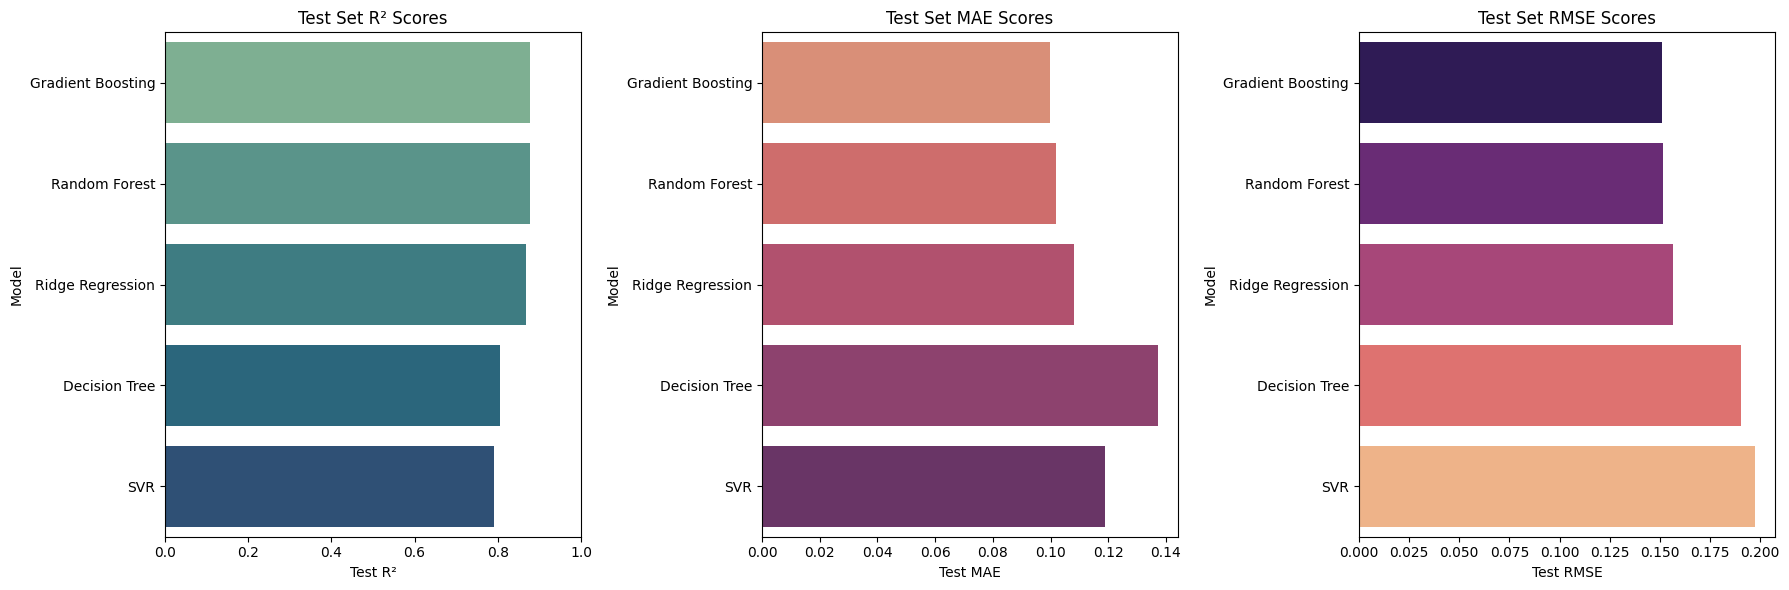

In [70]:
# Re-import necessary libraries after kernel reset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the test results dictionary
test_results = {
    "Model": [
        "Gradient Boosting", 
        "Random Forest", 
        "Ridge Regression", 
        "SVR", 
        "Decision Tree"
    ],
    "Test R²": [
        0.8774, 0.8766, 0.8686, 0.7908, 0.8058
    ],
    "Test MAE": [
        0.0998, 0.1018, 0.1081, 0.1189, 0.1373
    ],
    "Test RMSE": [
        0.1513, 0.1517, 0.1565, 0.1975, 0.1903
    ]
}

# Create DataFrame
test_results_df = pd.DataFrame(test_results)
test_results_df_sorted = test_results_df.sort_values(by="Test R²", ascending=False)

# Plot comparison for R², MAE, and RMSE
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=test_results_df_sorted, y="Model", x="Test R²", ax=axes[0], palette="crest", hue="Model", legend=False)
axes[0].set_title("Test Set R² Scores")
axes[0].set_xlim(0, 1)

sns.barplot(data=test_results_df_sorted, y="Model", x="Test MAE", ax=axes[1], palette="flare", hue="Model", legend=False)
axes[1].set_title("Test Set MAE Scores")

sns.barplot(data=test_results_df_sorted, y="Model", x="Test RMSE", ax=axes[2], palette="magma", hue="Model", legend=False)
axes[2].set_title("Test Set RMSE Scores")

plt.tight_layout()
plt.show()

### Observations:

- Gradient Boosting and Random Forest are top performers with R² scores close to 0.88, indicating excellent model fit and generalization on unseen data.
- Gradient Boosting has the lowest MAE (0.0998) and RMSE (0.1513), making it the most accurate and consistent model across all metrics.
- Ridge Regression also performs robustly with a high R² (0.8686), and its lower MAE and RMSE confirm its strong linear modeling capability.
- SVR and Decision Tree trail behind in all three metrics, with higher errors and comparatively lower R² values, suggesting limited capacity to generalize complex price patterns.

**Recommendation:** 

Gradient Boosting should be the preferred model moving forward for deployment.

## Residual Analysis

### Objective

- Residual analysis helps assess the performance of regression models by visualizing and interpreting the difference between predicted and actual values (residuals). This is crucial to:
- Identify non-random patterns or bias.
- Detect heteroscedasticity (changing variance across predictions).
- Ensure model assumptions (e.g., normality, independence) are not violated.
- Spot influential outliers that might distort model predictions.

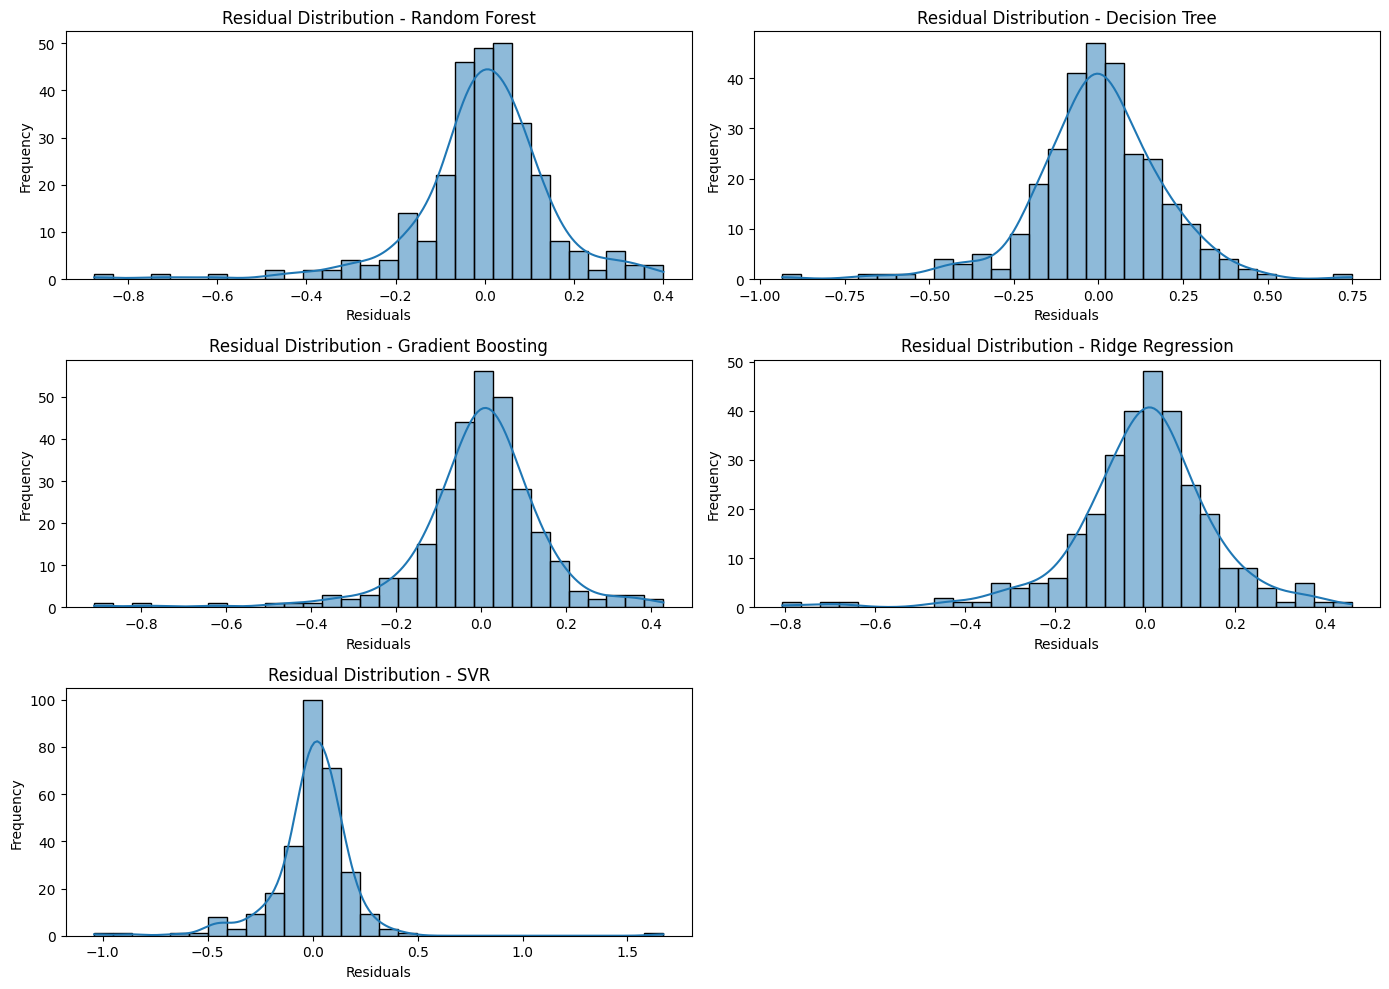

In [71]:
# Dictionary of tuned models
tuned_models = {
    "Random Forest": best_rf_model,
    "Decision Tree": best_dt_model,
    "Gradient Boosting": best_gbr_model,
    "Ridge Regression": best_ridge_model,
    "SVR": best_svr_model
}

# Plot residual distributions
plt.figure(figsize=(14, 10))

for idx, (name, model) in enumerate(tuned_models.items(), 1):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.subplot(3, 2, idx)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"Residual Distribution - {name}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


**Plot: Residuals vs. Predicted**

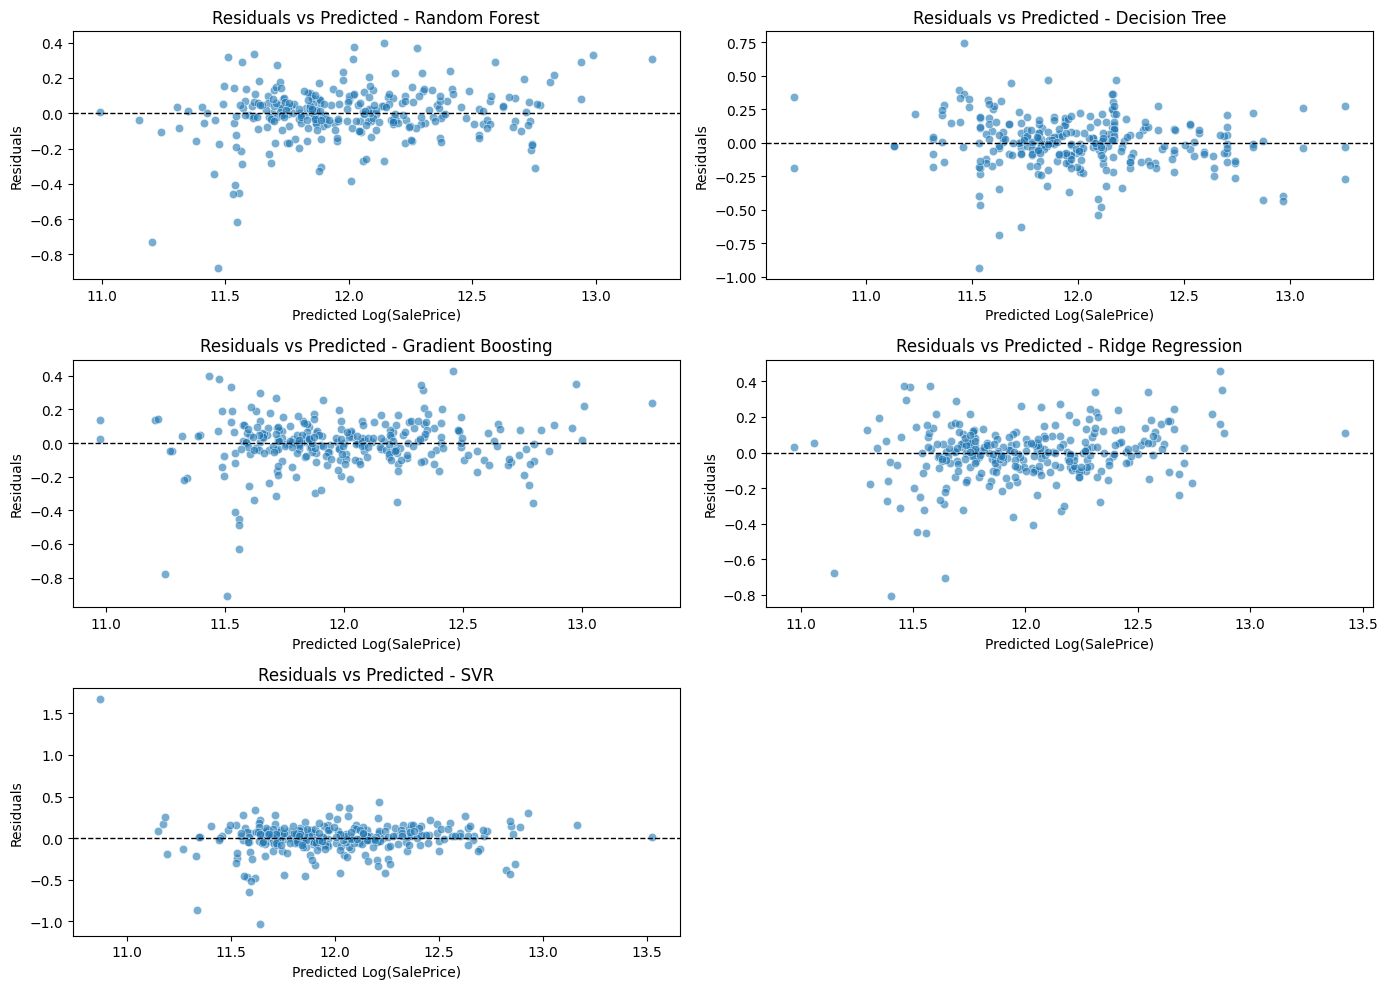

In [72]:
# Plot residuals vs predicted values
plt.figure(figsize=(14, 10))

for idx, (name, model) in enumerate(tuned_models.items(), 1):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.subplot(3, 2, idx)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, linestyle='--', color='black', linewidth=1)
    plt.title(f"Residuals vs Predicted - {name}")
    plt.xlabel("Predicted Log(SalePrice)")
    plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

### Observations

- Random Forest & Gradient Boosting showed tight, symmetrical residual distributions with minimal bias — validating their superior R² and RMSE scores.
- Ridge Regression produced reasonably centered residuals but had slightly longer tails, suggesting some underfitting on complex patterns.
- Decision Tree had higher error variance and showed signs of overfitting with outliers.
- SVR had wider scatter and some bias near the prediction extremes, confirming its slightly lower test R².

## Feature Importance & Insights

### Objective

In this section, we aim to identify which features have the greatest influence on house price predictions. Understanding feature importance helps:

- Interpret model decisions
- Guide further feature engineering
- Offer actionable insights for stakeholders (e.g., real estate clients)

We will analyze feature importance from Random Forest and Decision Tree models — both tree-based models that naturally compute feature contribution based on information gain.

We chose these models because they are:

- Intrinsically interpretable
- Robust for mixed feature types
- Aligned with the structure and complexity of real estate data


**Random Forest Regressor: Feature Importance**

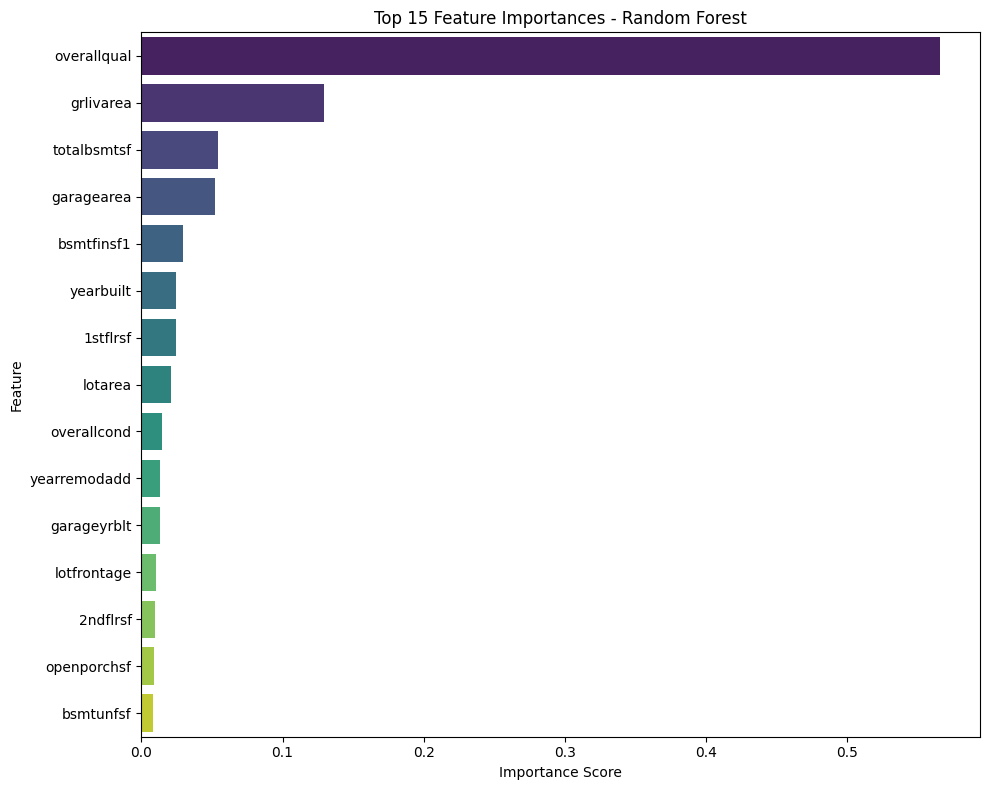

In [73]:
# Extract feature importances from the best Random Forest model
rf_importances = best_rf_model.feature_importances_
rf_features = X_train.columns

# Create DataFrame for plotting
rf_importance_df = pd.DataFrame({
    "Feature": rf_features,
    "Importance": rf_importances
}).sort_values(by="Importance", ascending=False)

# Plot Top 15 Features
plt.figure(figsize=(10, 8))
sns.barplot(data=rf_importance_df.head(15), x="Importance", y="Feature", palette="viridis", hue="Feature", legend=False)
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Decision Tree Regressor: Feature Importance**

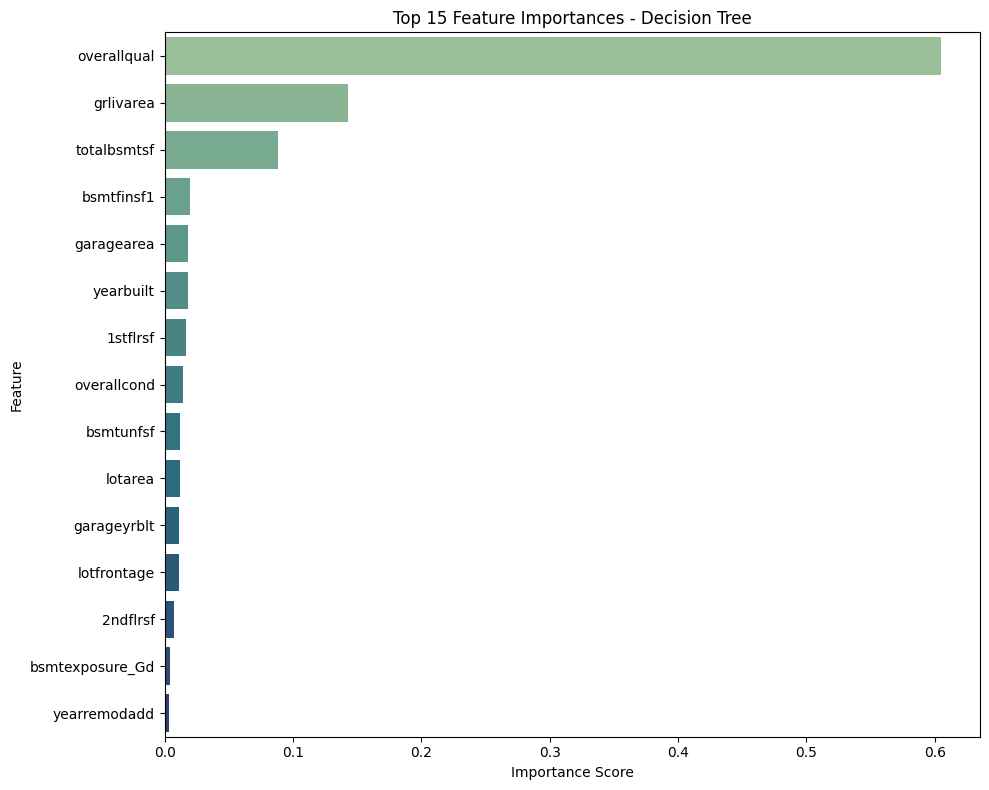

In [74]:
# Extract feature importances from the best Decision Tree model
dt_importances = best_dt_model.feature_importances_
dt_features = X_train.columns

# Create DataFrame for plotting
dt_importance_df = pd.DataFrame({
    "Feature": dt_features,
    "Importance": dt_importances
}).sort_values(by="Importance", ascending=False)

# Plot Top 15 Features
plt.figure(figsize=(10, 8))
sns.barplot(data=dt_importance_df.head(15), x="Importance", y="Feature", palette="crest", hue="Feature", legend=False)
plt.title("Top 15 Feature Importances - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#### Observations

- Overall Quality (num__OverallQual) ranked highest in both Random Forest and Decision Tree models, reinforcing its critical influence on sale prices.
- Above Ground Living Area (num__GrLivArea) and Garage Area (num__GarageArea) consistently showed high importance — supporting earlier correlation and residual analyses.
- Features like Finished Basement Ratio, Lot Area, and YearBuilt had medium to high importance, highlighting structure age and layout as price influencers.
- Low-importance features may still hold interaction effects (to be tested via SHAP/partial dependence next).

## Model Explainability

### (Random Forest) Objective

The goal of this section is to understand how the Random Forest model arrives at its predictions. This builds transparency and trust in the model’s behavior — especially for non-technical stakeholders. 

**We’ll focus on:**

- Identifying the most influential features globally.
- Understanding feature impact on individual predictions using SHAP (SHapley Additive exPlanations).
- Random Forests support intrinsic feature importance, and SHAP adds explainability at the individual prediction level.

**We will:**

- Revisit and visualize feature importances for both models
- Apply SHAP (SHapley Additive exPlanations) for deeper interpretability:
- Global interpretation: Understand which features drive predictions overall
- Local interpretation: Understand why the model made a specific prediction

**Import Model**

In [75]:
!pip install shap


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


**SHAP Summary Plot for Random Forest (Global Interpretability)**

[INFO] Checking for nulls in input datasets...
X_train null values:
 1stflrsf        0
2ndflrsf        0
bedroomabvgr    0
bsmtfinsf1      0
bsmtunfsf       0
dtype: int64
[INFO] Initializing SHAP explainer...
[INFO] Calculating SHAP values for X_test...
[INFO] Plotting SHAP summary plot (bar)...


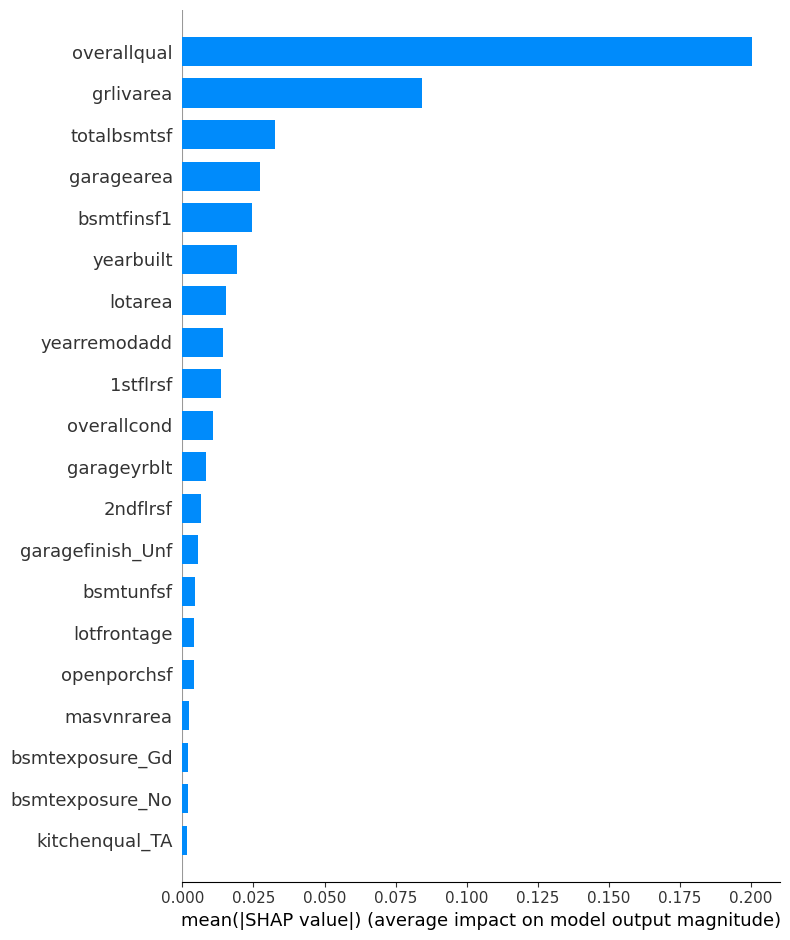

[INFO] Plotting SHAP summary plot (dot)...


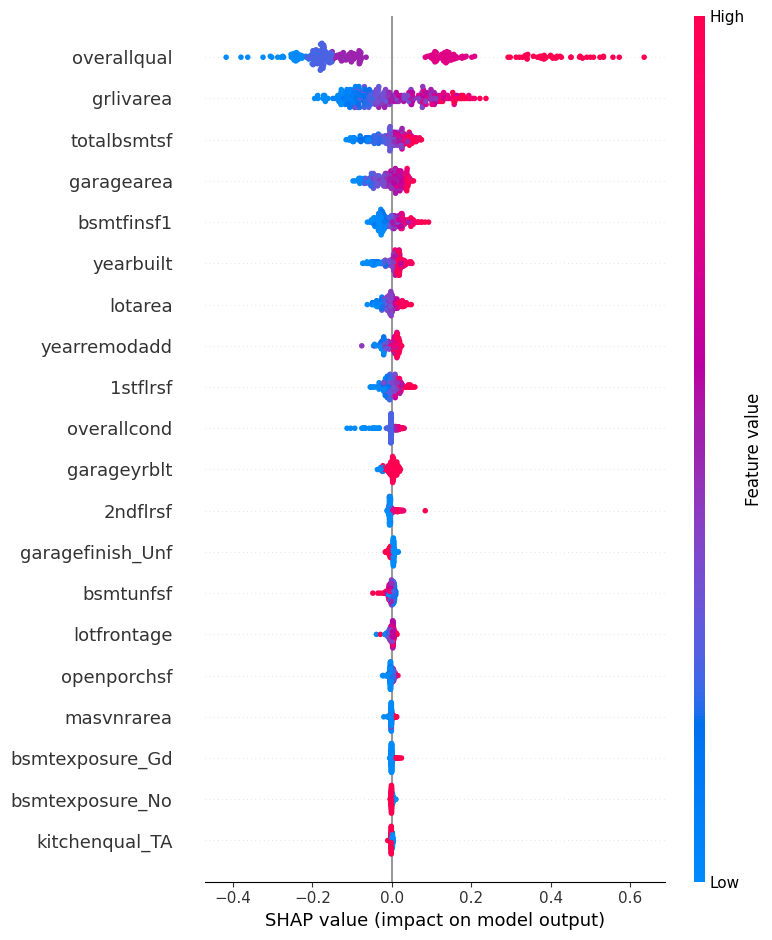

[INFO] Computing average SHAP contributions...
Top 10 Features by SHAP Contribution:
        Feature  Mean SHAP Value
0   overallqual         0.200133
1     grlivarea         0.084338
2   totalbsmtsf         0.032506
3    garagearea         0.027361
4    bsmtfinsf1         0.024495
5     yearbuilt         0.019095
6       lotarea         0.015186
7  yearremodadd         0.014271
8      1stflrsf         0.013741
9   overallcond         0.010863
Generating SHAP dependence plot for top feature...


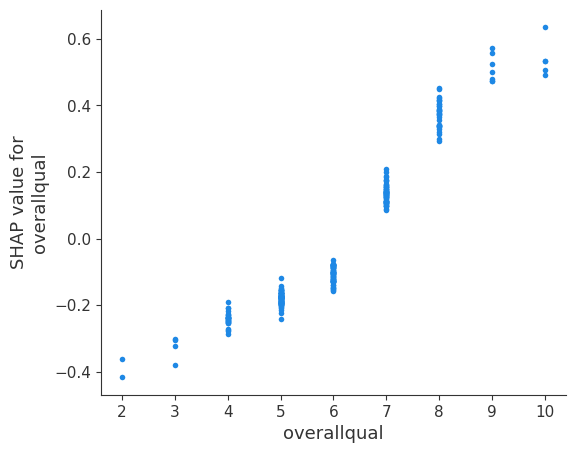

In [87]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Check for missing values
print("[INFO] Checking for nulls in input datasets...")
print("X_train null values:\n", X_train.isnull().sum().sort_values(ascending=False).head())

# Handle any missing values if found
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())  # avoid data leakage

# Initialize SHAP Tree Explainer
print("[INFO] Initializing SHAP explainer...")
explainer_rf = shap.TreeExplainer(best_rf_model)

# Compute SHAP values
print("[INFO] Calculating SHAP values for X_test...")
shap_values_rf = explainer_rf.shap_values(X_test_filled)

# Summary plot (bar)
print("[INFO] Plotting SHAP summary plot (bar)...")
shap.summary_plot(shap_values_rf, X_test_filled, plot_type="bar", show=True)

# Summary plot (dot)
print("[INFO] Plotting SHAP summary plot (dot)...")
shap.summary_plot(shap_values_rf, X_test_filled, show=True)

# SHAP Values Table — Mean absolute SHAP values per feature
print("[INFO] Computing average SHAP contributions...")
shap_rf_df = pd.DataFrame(shap_values_rf, columns=X_test_filled.columns)
shap_rf_mean = shap_rf_df.abs().mean(axis=0).sort_values(ascending=False)
shap_rf_table = pd.DataFrame({
    "Feature": shap_rf_mean.index,
    "Mean SHAP Value": shap_rf_mean.values
})

# Display top 10 contributing features
print("Top 10 Features by SHAP Contribution:")
print(shap_rf_table.head(10))

# SHAP Dependence Plot for Overall Quality (or top-ranked feature)
print("Generating SHAP dependence plot for top feature...")

top_feature = shap_rf_table["Feature"].iloc[0]
shap.dependence_plot(
    top_feature,
    shap_values_rf,
    X_test_filled,
    interaction_index=None,
    show=True
)

### (XGBoost) Objective

To understand how XGBoost makes predictions by analyzing feature-level contributions using SHAP (SHapley Additive exPlanations). This enhances model transparency and supports interpretability.

Top 10 Contributing Features (XGBoost SHAP):


,Feature,Mean SHAP Value
13,overallqual,0.153576
7,grlivarea,0.096429
14,totalbsmtsf,0.035504
15,yearbuilt,0.032242
3,bsmtfinsf1,0.030743
5,garagearea,0.030488
12,overallcond,0.029835
8,lotarea,0.023741
16,yearremodadd,0.023463
0,1stflrsf,0.010861


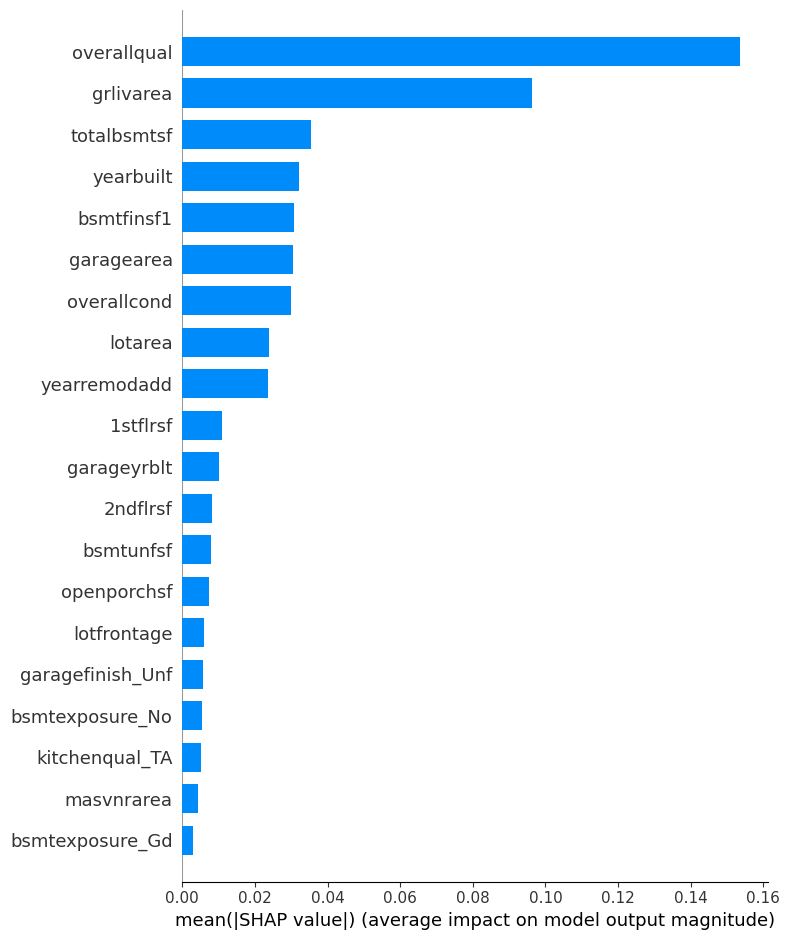

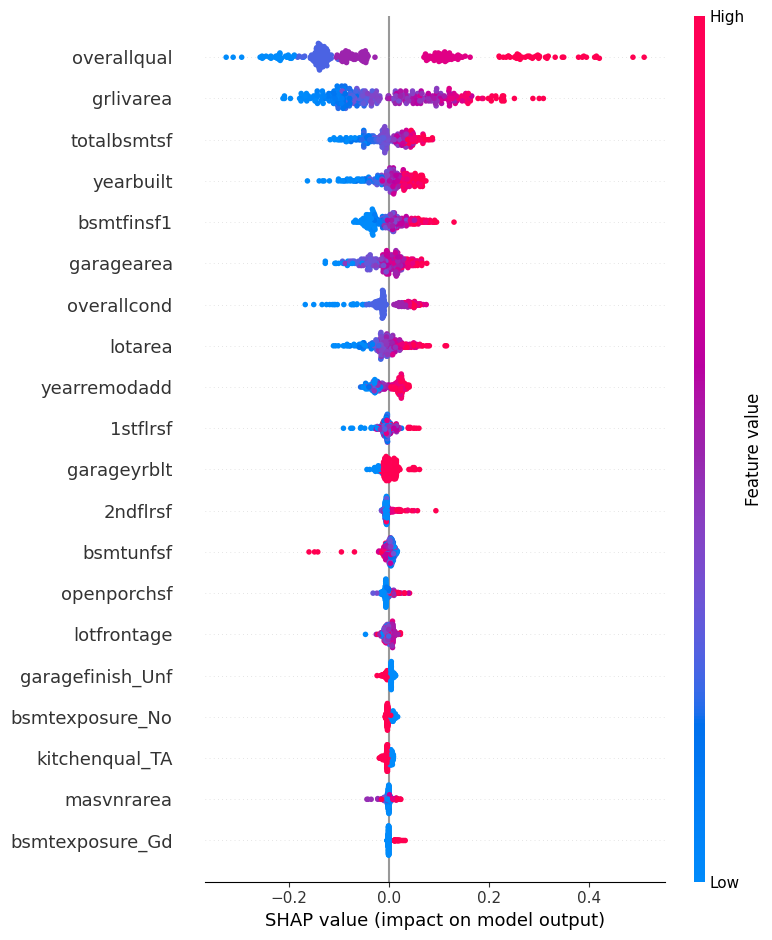

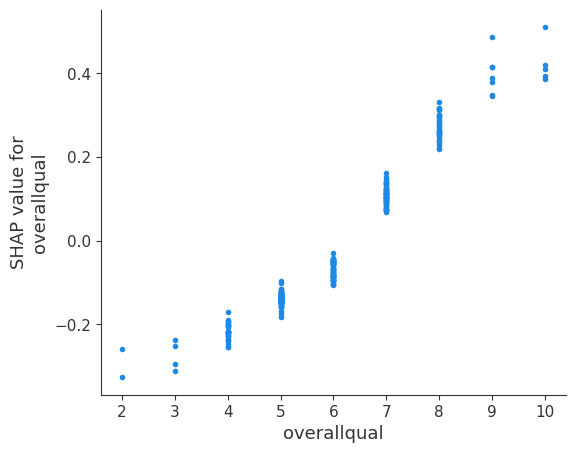

In [86]:
import shap

# Create SHAP explainer for XGBoost
explainer_gbr = shap.Explainer(best_gbr_model)

# Compute SHAP values for the test data
shap_values_gbr = explainer_gbr(X_test_filled)

# Calculate mean absolute SHAP values per feature
shap_mean_gbr = np.abs(shap_values_gbr.values).mean(axis=0)

# Create a DataFrame of feature importances
shap_importance_gbr_df = pd.DataFrame({
    "Feature": X_test_filled.columns,
    "Mean SHAP Value": shap_mean_gbr
}).sort_values(by="Mean SHAP Value", ascending=False)

# Display Top 10 features
print("Top 10 Contributing Features (XGBoost SHAP):")
display(shap_importance_gbr_df.head(10))

# SHAP Bar Plot - Global Importance
shap.summary_plot(shap_values_gbr, X_test_filled, plot_type="bar", show=True)

# SHAP Beeswarm Plot - Overall Distribution
shap.summary_plot(shap_values_gbr, X_test_filled, show=True)

# Pick the top SHAP feature
top_feature_gbr = X_test_filled.columns[np.argsort(np.abs(shap_values_gbr.values).mean(0))[::-1][0]]

# Dependence plot
shap.dependence_plot(
    top_feature_gbr,
    shap_values_gbr.values,
    X_test_filled,
    interaction_index=None
)

#### SHAP Feature Contribution Observations:

The SHAP value analysis for both XGBoost and Random Forest reveals strong consensus on the most influential features driving house price predictions. Here's a breakdown of key observations:

**Common Top Contributors**

1. overallqual (Overall Quality):

- Ranked #1 in both models.
- It shows the highest SHAP value across the board, confirming it's the most decisive factor in predicting sale price.

Observation: Property quality is perceived and priced as a premium attribute, reaffirming earlier correlation and importance plots.

2. grlivarea (Above-Ground Living Area):

- Consistently ranked #2, with strong SHAP values.

Observation: Larger, usable living areas have direct positive impact on value perception and final pricing.

3. totalbsmtsf, bsmtfinsf1 (Basement Area & Finish):

- Appear in top 5 in both models.

Observation: Finished and spacious basements add perceived livability and investment value.

4. yearbuilt & yearremodadd:

- Reflects recency of construction or upgrades, appearing in top 10 consistently.

Observation: Modern or recently renovated homes command higher prices due to reduced maintenance risk and updated features.

5. garagearea:

- Present in both lists.

Observation: Functional garages are a valuable utility space, especially in suburban residential markets.

**Model-Specific Insights**

- Random Forest gives slightly more weight to overallqual, while XGBoost distributes importance a bit more evenly across additional features like overallcond, lotarea, and 1stflrsf.
- overallcond is ranked higher by XGBoost than Random Forest, suggesting it captures more subtle condition nuances XGBoost may handle better.

#### Final Takeaway
- These insights validate our earlier EDA conclusions — confirming that quality, size, and condition are core price drivers.
- SHAP strengthens our model explainability, offering transparency and interpretability critical for client trust and business deployment.

## Save Results

We will now retain the trained models, processed data, and pertinent outputs, like evaluation metrics and feature importance statistics, to guarantee reproducibility and make additional analysis easier. These saved files can be used in notebooks or projects in the future.